In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


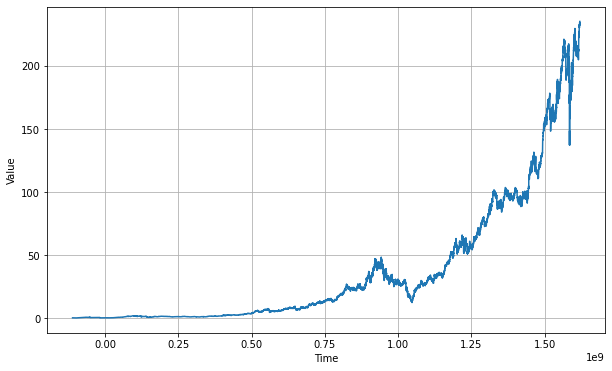

In [6]:
import csv
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def plot_series_all(time, data, title='Asset price', xlabel='year', ylabel='price'):
    plt.plot(time, data)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.show()

def read_data(filepath='../data/BTC-USD.csv'):
    DATE_FORMAT = "%Y-%m-%d"
    time_step = []
    prices = []
    with open(filepath) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader) # skip header
        for row in reader:
            if row[4] != 'null':
                date = datetime.strptime(row[0], DATE_FORMAT)
                time_step.append(datetime.timestamp(date))
                prices.append(float(row[4]))
    return np.array(time_step, dtype="float32"), np.array(prices, dtype="float32")

time, series = read_data()
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

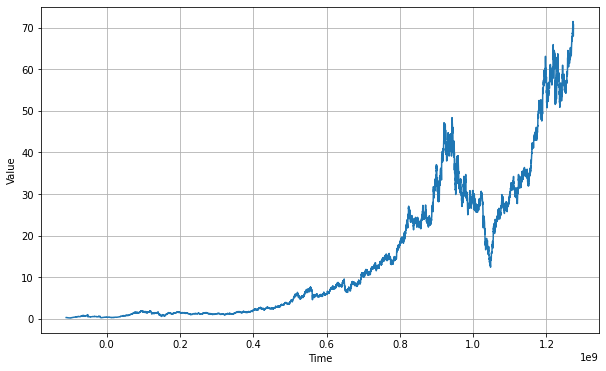

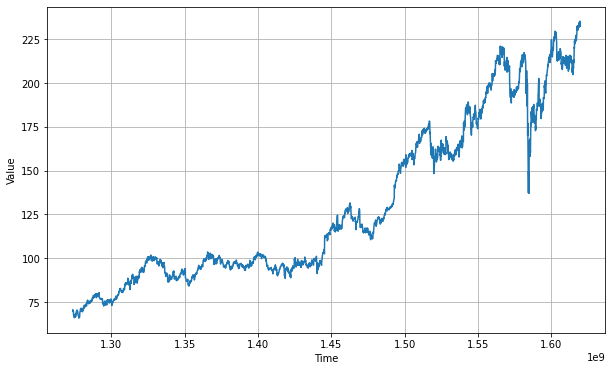

In [7]:
split_time = int(len(time) * 0.8)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=2)

KeyboardInterrupt: 

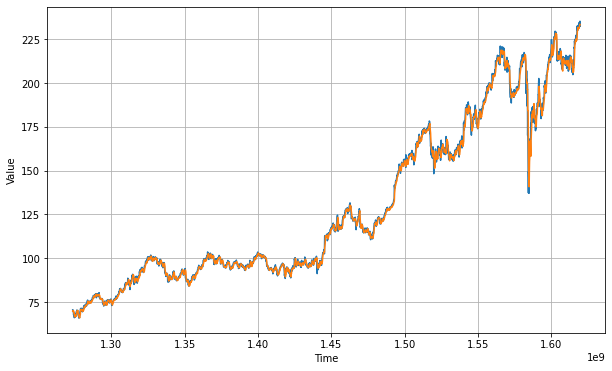

In [9]:
forecast = []

for time in range(len(series) - window_size):
    series_window = series[time:time + window_size]
    # series_window_expanded = np.expand_dims(series_window, axis=0)
    series_window_expanded = series_window[np.newaxis]
    predicted_value = model.predict(series_window_expanded)
    forecast.append(predicted_value)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

6.0014577